# 2D Pose Estimation

In [1]:
%matplotlib inline

from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from PIL import Image
import numpy as np

## Build the dataset

![Dataset Joints](res/joints.png)

In [2]:
IMG_FOLDER = 'images'
release = loadmat('mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat')['RELEASE']

In [6]:
data = []
d_c = 0

# Code adapted from: https://github.com/mitmul/deeppose/blob/master/datasets/mpii_dataset.py
for i, anno in enumerate(release['annolist'][0, 0][0]):

    img_fn = anno['image']['name'][0, 0][0]
    head_rect = []
    
    if release['img_train'][0,0][0][i] == 0:
        d_c += 1

    if 'annopoints' in str(anno['annorect'].dtype):
        annopoints = anno['annorect']['annopoints'][0]
        head_x1s = anno['annorect']['x1'][0]
        head_y1s = anno['annorect']['y1'][0]
        head_x2s = anno['annorect']['x2'][0]
        head_y2s = anno['annorect']['y2'][0]

        count = 0
        h = []
        j = []
        discard = False
        for annopoint, head_x1, head_y1, head_x2, head_y2 in zip(annopoints, head_x1s, head_y1s, 
                                                                 head_x2s, head_y2s):
            count += 1
            if annopoint != []:
                head_rect = [float(head_x1[0, 0]),
                             float(head_y1[0, 0]),
                             float(head_x2[0, 0]),
                             float(head_y2[0, 0])]

                # joint coordinates
                annopoint = annopoint['point'][0, 0]
                j_id = [j_i[0, 0] for j_i in annopoint['id'][0]]
                x = [x[0, 0] for x in annopoint['x'][0]]
                y = [y[0, 0] for y in annopoint['y'][0]]
                joint_pos = {}
                for _j_id, (_x, _y) in zip(j_id, zip(x, y)):
                    joint_pos[_j_id] = [float(_x), float(_y)]
                    
                h.append(head_rect)
                j.append(joint_pos)

        data.append({'filename': img_fn,
                     'n_people': count,
                     'head_rect': h,
                     'joint_pos': j
                    })
                    

/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: elementwise != comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


### Split into train-test

__NOTE__: We ignore the default train - test annotations because of examples with missing joint annotations. We first get the annotated examples, and then perform the train-test split.

In [7]:
train, test = train_test_split(data, test_size=0.1)
del data

Test examples are not annotated, and some training examples (671) miss joint annotations.

In [8]:
len(train) + len(test) + d_c # Different from 

24316

### Visualize some train data

In [184]:
joint_unions = [(8, 12), (12, 11), (11, 10), (8, 13), (13, 14), (14, 15), (8, 7), (7, 6), (6, 2), \
                (2, 1), (1, 0), (6, 3), (3, 4), (4, 5)]

def plot_skeleton(data_dict):
    """
    Input:
        - data_dict: dictionary with fields ['filename' or 'img', 'head_rect', 'joint_pos']
    Output:
        - plot of the image with the joint skeletons drawn above
    """
    is_crop = False
    
    if 'filename' in data_dict.keys():
        img = mpimg.imread(f'{IMG_FOLDER}/{data_dict["filename"]}')
        plt.figure(figsize=(16,16))
        plt.imshow(img)
    elif 'img' in data_dict.keys():
        img = data_dict['img']
        is_crop = True
    
    for i in range(data_dict['n_people']):
        if is_crop:
            plt.figure(figsize=(6,6))
            plt.imshow(img[i])
        
        plt.plot([data_dict['head_rect'][i][0], data_dict['head_rect'][i][0]], 
                 [data_dict['head_rect'][i][1], data_dict['head_rect'][i][3]],
                 c='blue', lw=3)
        plt.plot([data_dict['head_rect'][i][0], data_dict['head_rect'][i][2]], 
                 [data_dict['head_rect'][i][3], data_dict['head_rect'][i][3]],
                 c='blue', lw=3)
        plt.plot([data_dict['head_rect'][i][2], data_dict['head_rect'][i][2]], 
                 [data_dict['head_rect'][i][1], data_dict['head_rect'][i][3]],
                 c='blue', lw=3)
        plt.plot([data_dict['head_rect'][i][0], data_dict['head_rect'][i][2]], 
                 [data_dict['head_rect'][i][1], data_dict['head_rect'][i][1]],
                 c='blue', lw=3)

        for o, t in joint_unions:
            try:
                plt.plot([data_dict['joint_pos'][i][o][0], data_dict['joint_pos'][i][t][0]], 
                         [data_dict['joint_pos'][i][o][1], data_dict['joint_pos'][i][t][1]],
                         lw=3)
            except KeyError:
                pass
        
        if is_crop:
            plt.axis('off')
            
    if not is_crop:
        plt.axis('off')
    

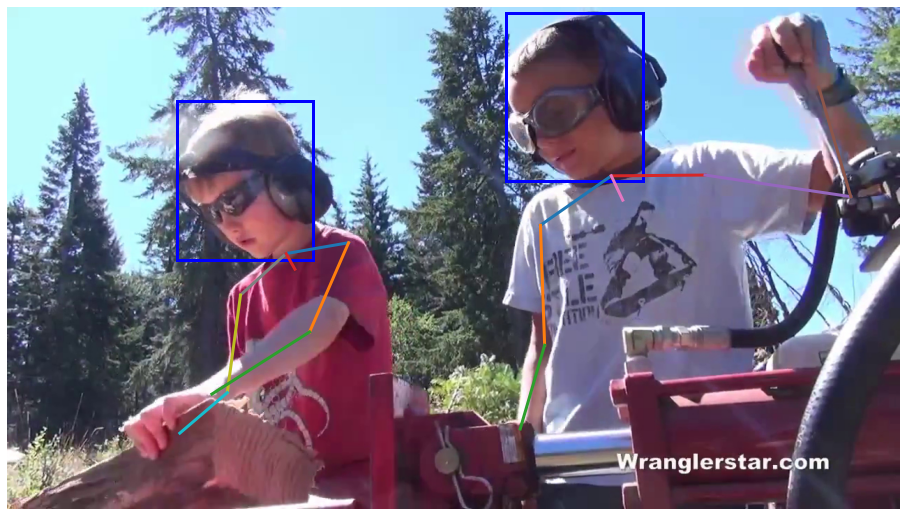

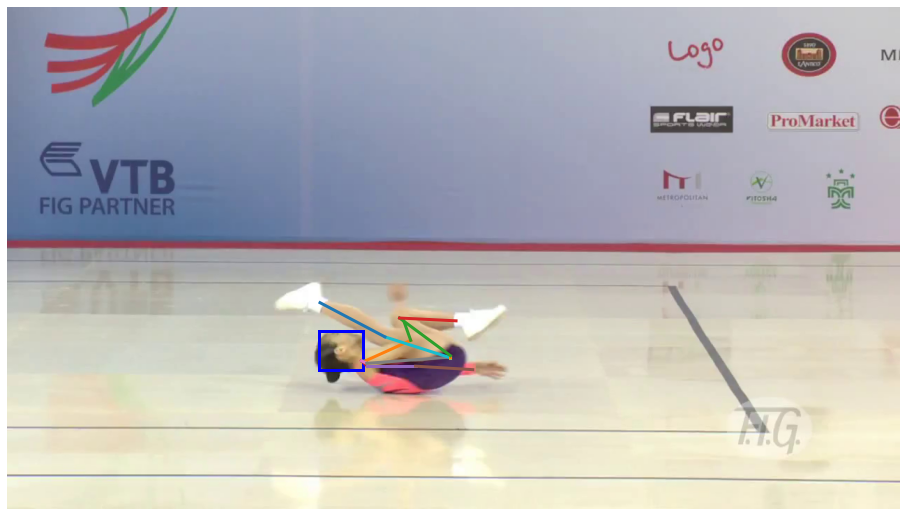

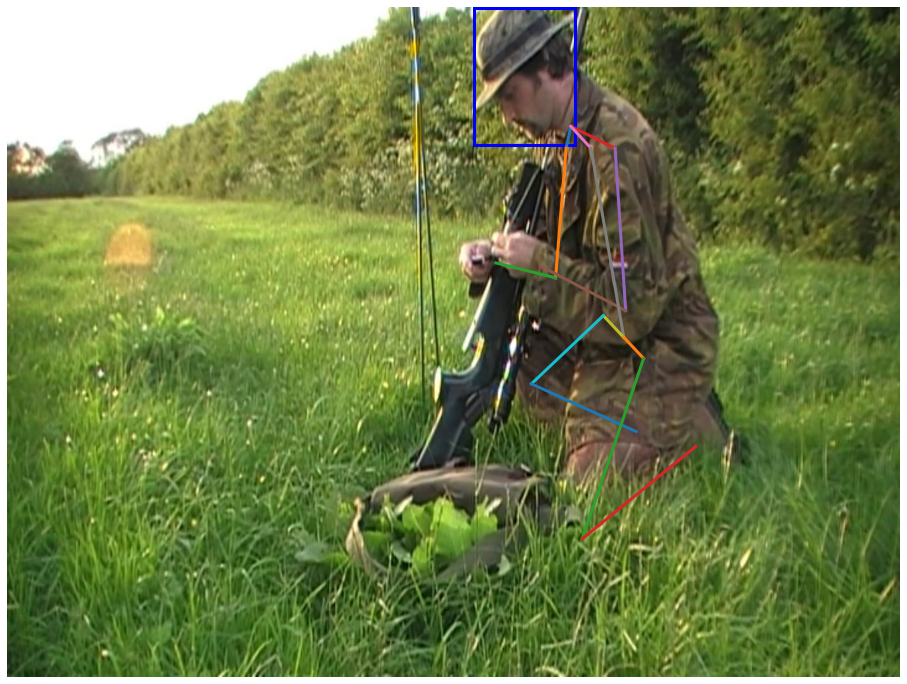

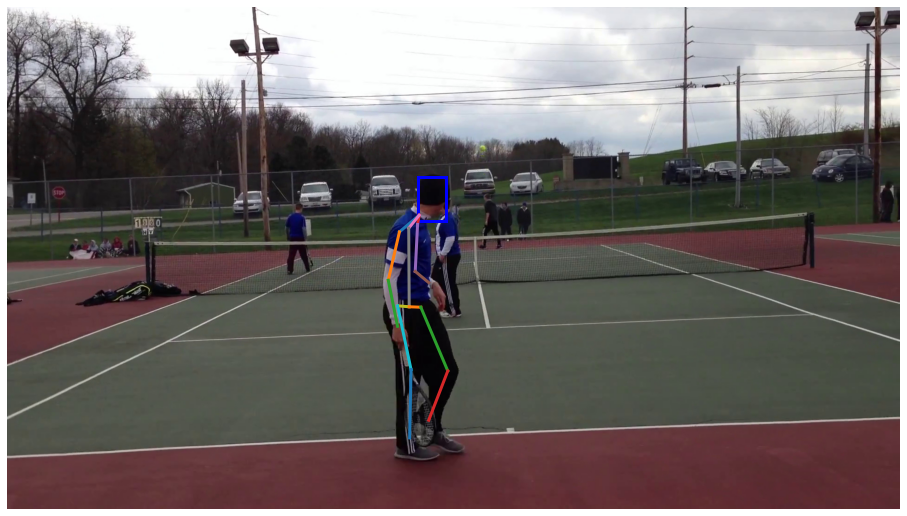

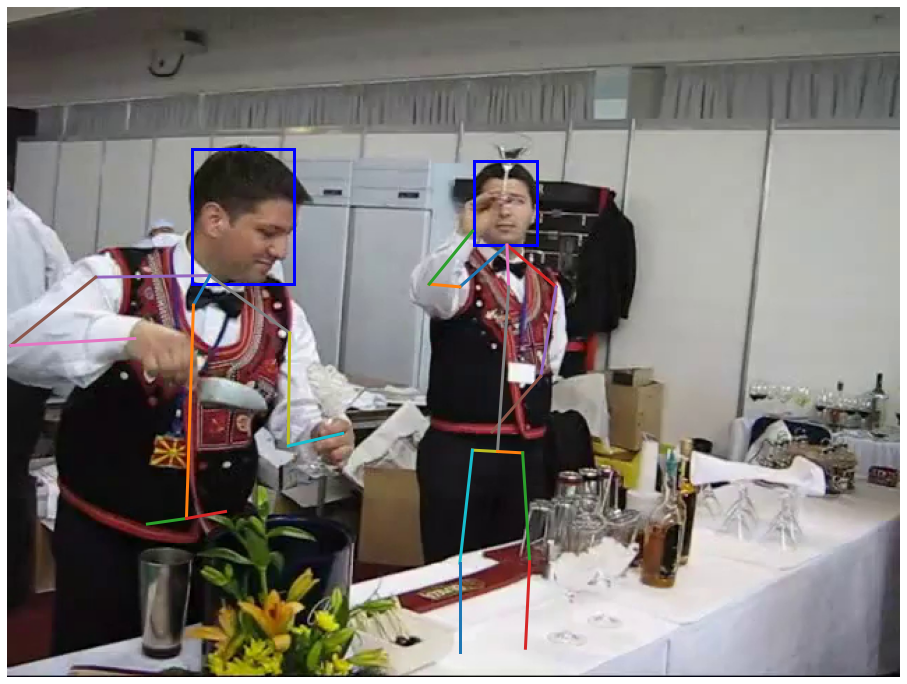

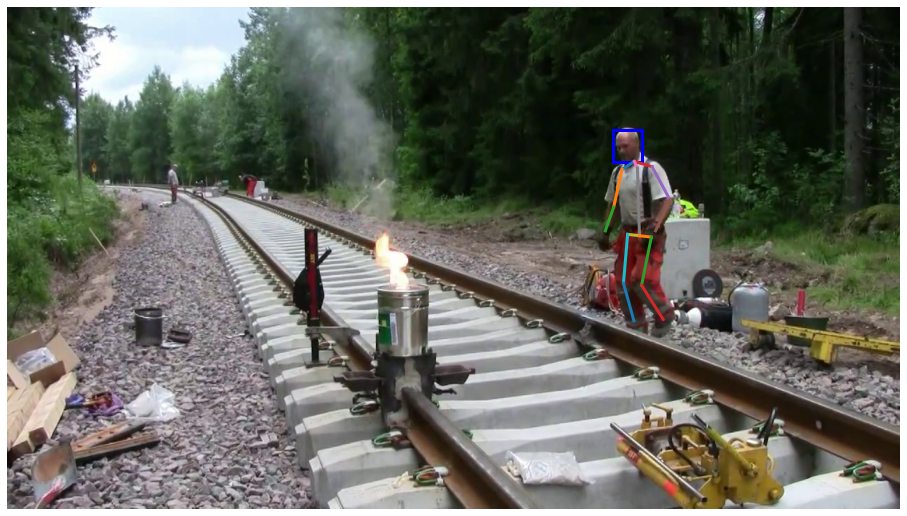

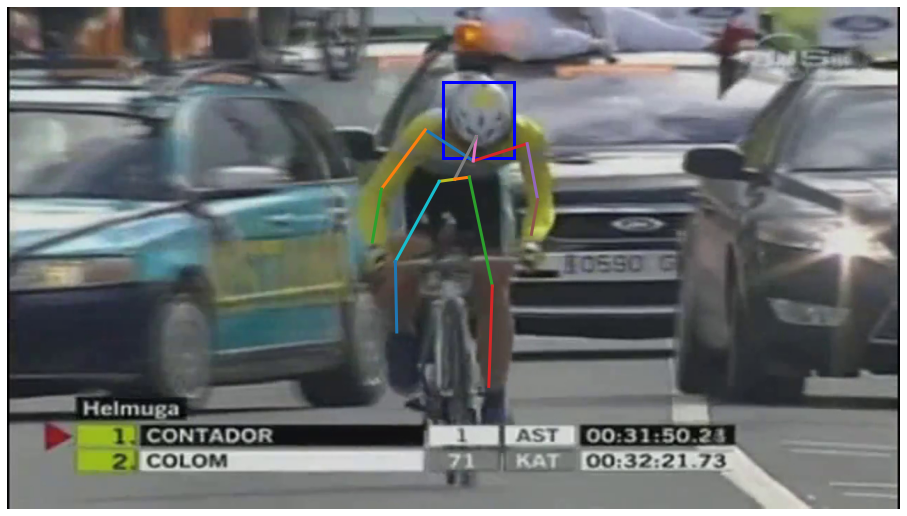

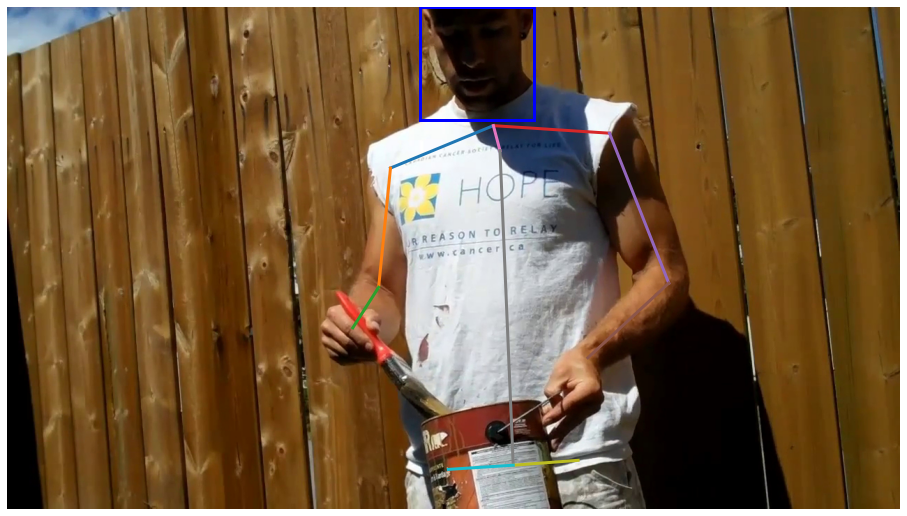

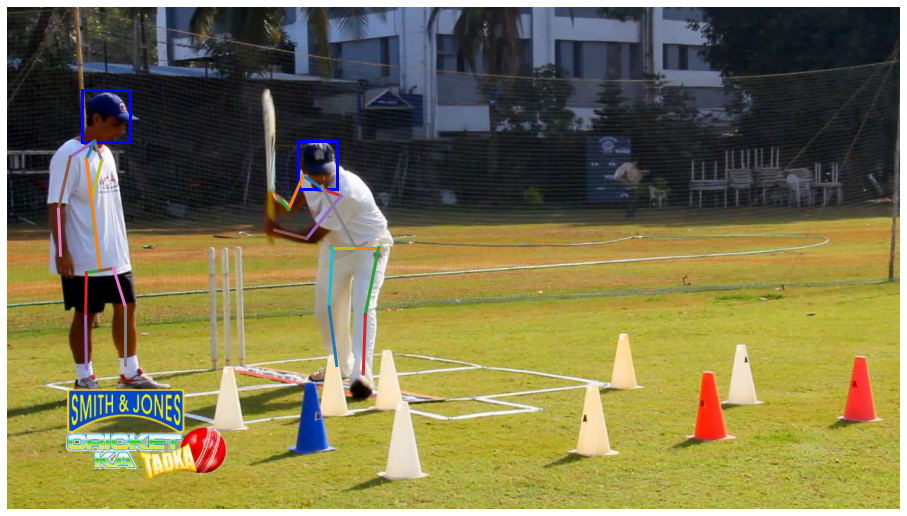

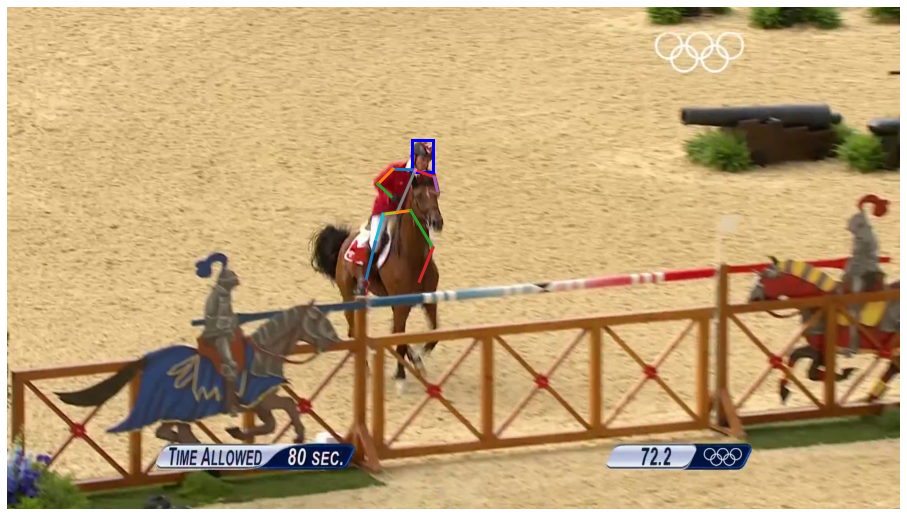

In [185]:
for i in range(10):
    plot_skeleton(train[np.random.randint(len(train))])

## Preprocessing

In [160]:
def crop_resize_humans(data_dict):
    j = []
    h = []
    im = []
    for i in range(data_dict['n_people']):
        points = data_dict["joint_pos"][i]
        p_values = [*points.values()]
        head = data_dict["head_rect"][i]

        x_points = [item[0] for item in p_values]
        y_points = [item[1] for item in p_values]

        img = Image.open(f'{IMG_FOLDER}/{data_dict["filename"]}')
        x_shape, y_shape = img.size

        head_size = head[2] - head[0]

        y_max = int(min(max(y_points) + head_size, y_shape))
        y_min = int(max(min(y_points) - head_size, 0))
        x_max = int(min(max(x_points) + head_size, x_shape))
        x_min = int(max(min(x_points) - head_size, 0))
        
        crop_img = img.crop((x_min, y_min, x_max, y_max))
 
        resized_img = crop_img.resize((256,256))

        translation =  np.array([x_min, y_min])
 
        new_points = (np.array(p_values) - translation)*resized_img.size/crop_img.size
        n_p = {}
        for k, v in zip(points.keys(), new_points):
            n_p[k] = v
    
        new_head = np.concatenate(((np.array(head[:2]) - translation)*resized_img.size/crop_img.size, \
                                   (np.array(head[2:]) - translation)*resized_img.size/crop_img.size))
        
        h.append(new_head)
        j.append(n_p)
        im.append(resized_img)
        
    return {'img': im, 'n_people': data_dict['n_people'], 'head_rect': h, 'joint_pos': j}

In [176]:
d = crop_resize_humans(train[2000])

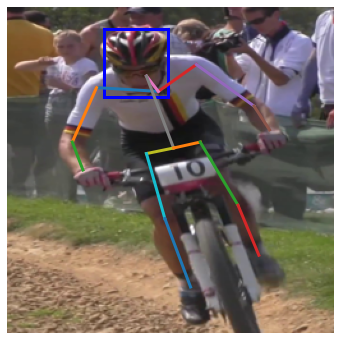

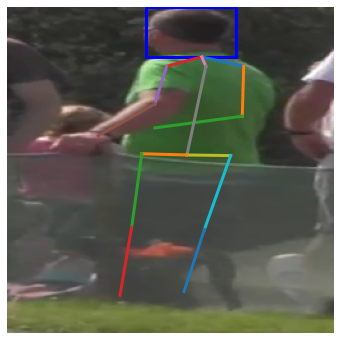

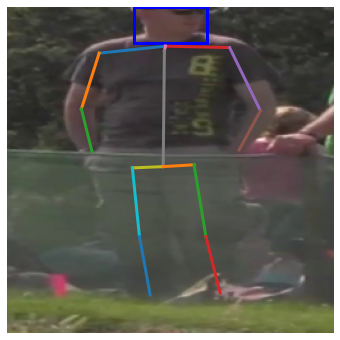

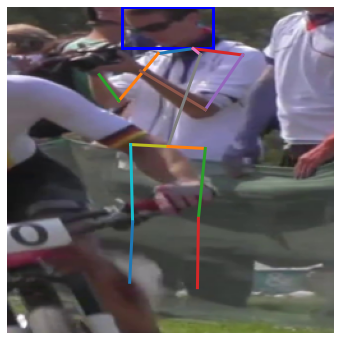

In [177]:
plot_skeleton(d)

## Heatmap generation

In [189]:
# Code adapted from https://github.com/ildoonet/tf-pose-estimation/blob/master/tf_pose/pose_dataset.py
# It creates a 2D gaussian (with standard deviation of sigma px) around center
def put_heatmap(heatmap, center, sigma):
        center_x, center_y = center
        height, width = heatmap.shape

        th = 4.6052
        delta = np.sqrt(th * 2)

        x0 = int(max(0, center_x - delta * sigma))
        y0 = int(max(0, center_y - delta * sigma))

        x1 = int(min(width, center_x + delta * sigma))
        y1 = int(min(height, center_y + delta * sigma))

        for y in range(y0, y1):
            for x in range(x0, x1):
                d = (x - center_x) ** 2 + (y - center_y) ** 2
                exp = d / 2.0 / sigma / sigma
                if exp > th:
                    continue
                heatmap[y][x] = max(heatmap[y][x], np.exp(-exp))
                heatmap[y][x] = min(heatmap[y][x], 1.0)

In [196]:
def generate_heapmap(data_dict):
    if data
    h = np.zeros(data_dict)

array([[0.01831564, 0.082085  , 0.13533528, 0.082085  ],
       [0.082085  , 0.36787945, 0.60653067, 0.36787945],
       [0.13533528, 0.60653067, 1.        , 0.60653067],
       [0.082085  , 0.36787945, 0.60653067, 0.36787945]], dtype=float32)

## Build the CNN architecture